# 🧠 Customer Segmentation and Behavioral Profiling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Load and clean data

In [2]:
df = pd.read_csv("data/sales.csv", sep=';', encoding='utf-8')
df['OrderDate'] = pd.to_datetime(df['OrderDateKey'], format='%Y%m%d')
df['Unit Price'] = df['Unit Price'].str.replace(',', '.').astype(float)
df['Product Standard Cost'] = df['Product Standard Cost'].str.replace(',', '.').astype(float)

# Keep only retail customers
df = df[df['CustomerKey'] != -1]

# Filter for valid rows
df = df[(df['Order Quantity'] > 0) & (df['Unit Price'] > 0) & (df['Product Standard Cost'] >= 0)]

# Drop unused columns
df.drop(columns=[
    'ResellerKey', 'ProductKey', 'OrderDateKey', 'Unit Price Discount Pct',
    'Customer Key', 'FullName', 'SalesOrderLineKey'
], inplace=True)

## Feature engineering

In [3]:
df['Revenue'] = df['Unit Price'] # 'Order Quantity' == 1 for all records
df['Profit'] = df['Revenue'] - df['Product Standard Cost']
customer_age = df.groupby('CustomerKey').agg(
    First=('OrderDate', 'min'),
    Last=('OrderDate', 'max')
)
customer_age['CustomerAgeDays'] = (customer_age['Last'] - customer_age['First']).dt.days + 1

## Client-level aggregation

In [4]:
agg = df.groupby('CustomerKey').agg({
    'Revenue': 'sum',
    'Profit': 'sum',
    'OrderDate': 'count'
}).rename(columns={'OrderDate': 'OrderCount'})

agg = agg.merge(customer_age[['CustomerAgeDays']], left_index=True, right_index=True)

agg['AvgOrderValue'] = agg['Revenue'] / agg['OrderCount']
agg['ProfitMargin'] = agg['Profit'] / agg['Revenue']

agg = agg[agg['Revenue'] > 0].dropna() # Possible deletion of empty and worthless records

In [5]:
agg.head()

,Revenue,Profit,OrderCount,CustomerAgeDays,AvgOrderValue,ProfitMargin
CustomerKey,,,,,,
11000,8248.99,3513.6905,8,815,1031.123750,0.425954
11001,6383.88,2795.8839,11,1039,580.352727,0.437960
11002,8114.04,3454.8801,4,753,2028.510000,0.425790
11003,8139.29,3467.1264,9,833,904.365556,0.425974
11004,8196.01,3501.9051,6,811,1366.001667,0.427270


## Customer clustering (KMeans)

In [6]:
features = ['Revenue', 'Profit', 'AvgOrderValue', 'ProfitMargin', 'CustomerAgeDays']
X_seg = agg[features].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_seg)

kmeans = KMeans(n_clusters=4, random_state=42)
agg['Cluster'] = kmeans.fit_predict(X_scaled)

## Interpretation of results

In [7]:
agg.groupby('Cluster')[features].mean()

,Revenue,Profit,AvgOrderValue,ProfitMargin,CustomerAgeDays
Cluster,,,,,
0,5870.658669,2414.911459,1377.978133,0.410663,657.978503
1,62.676634,38.168033,21.402221,0.619292,27.293152
2,2973.785706,1226.022078,1247.953995,0.411689,282.316642
3,833.256776,321.864902,312.025869,0.385873,20.345255


### Mapping labels to clusters

In [8]:
cluster_labels = {
    0: "Loyal High-Spenders", # long with us, solid orders
    1: "High-Margin One-Timers", # disappearing quickly, but very profitable
    2: "Mid-Term Key Accounts", # valuable, but shorter with us
    3: "Low-Value Shoppers" # cheap, short, weak
}

agg['Segment'] = agg['Cluster'].map(cluster_labels)

### Cluster Visualization

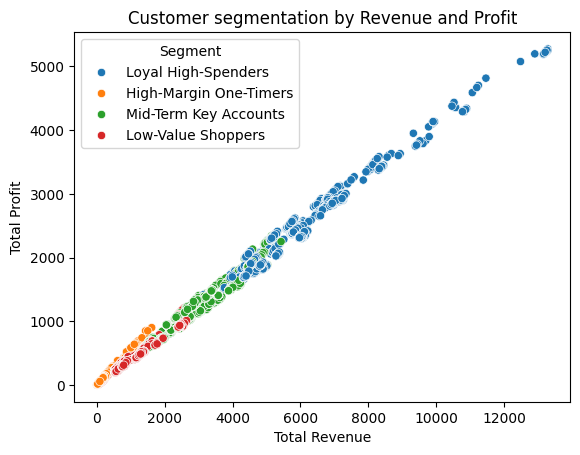

In [9]:
sns.scatterplot(data=agg, x='Revenue', y='Profit', hue='Segment', palette='tab10')
plt.title("Customer segmentation by Revenue and Profit")
plt.xlabel("Total Revenue")
plt.ylabel("Total Profit")
plt.show()

## Export Segment Data

In [10]:
agg.reset_index().to_csv("data/customer_segments.csv", index=False)
agg.groupby('Segment')[features].mean().to_csv("data/segment_profiles.csv")